[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0087DeepLearningConv2DFashionMNIST.ipynb)

The data can be downloaded from:
https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1/data

In [3]:
# Import Packages
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torchinfo
from torchmetrics.classification import MulticlassAccuracy
from torchvision.transforms import v2 as TorchVisionTrns


# Miscellaneous
import math
import os
from dotenv import load_dotenv

from platform import python_version
from platform import python_version
import random
import time

# Typing
from typing import Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

import pytest
import nibabel as nib
import os
from nibabel.testing import data_path
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate
from sklearn import preprocessing as pre
from keras.utils import to_categorical 
import torch.optim.lr_scheduler as lr_scheduler
import numpy.ma as ma
from datasets import ImageDatasetFromDisk


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [4]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False


In [5]:
# Constants


IMG_SIZE = (240,240,155)

TENSOR_BOARD_BASE   = 'TB'



In [6]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [7]:
# Courses Packages

from DataVisualization import PlotLabelsHistogram, PlotMnistImages
from DeepLearningPyTorch import TrainModel
from unet3d import UNet3D
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import Dice
import gzip


In [8]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev)


In [9]:
load_dotenv()

def str_to_bool(s):
    return s.lower() in ('true', '1')
print(os.getenv("NUMPY_ARCHIVE_PATH"))

E:/BRaTS_2021/numpy_data/


## Brain Tumor Image Classification using DL




In [10]:
# Parameters

# Data
numSamplesTrain = 0 #TBD after we know how many samples we have
numSamplesTest  = 0 #TBD after we know how many samples we have
trainTestPercentage = 0.2
# Model
dropP = 0.2 #<! Dropout Layer

# Training
batchSize   = 1
numWork     = 2 #<! Number of workers
nEpochs     = 5

# Visualization
numImg = 3

# samples root directory
root_dir = os.getenv("ROOT_DIR") #The directeroy of the original Kaggel archive. 
numpy_archive_path = os.getenv("NUMPY_ARCHIVE_PATH") #the root directory of the processed numpy samples 
image_path = numpy_archive_path +'new_archive_cat/images/'  # path to the processed numpy images 
label_path = numpy_archive_path +'new_archive_cat/labels/'  # path to the processed numpy labeles 


# image types
img_types = ['t1','t1ce','t2','flair','seg']


#number of pixels in an image
p_image_size = IMG_SIZE[0]*IMG_SIZE[1]*IMG_SIZE[2]
crop_size = (128,160,128)


## Generate Data

* Read the Kaggle archive (https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1) and process it to numpy images to be saved to the disk.
* Those functions are used only once to generate the data.
* If you have the processed data already skip this section.

In [11]:
#These functions to be run once to generate the numpy files containing the images
def get_file_lists():
   files = os.listdir(root_dir)
   
   file_list = []
   
   for file_name in files:
     if os.path.isdir(root_dir +file_name):
      all_samples_dirs = os.listdir(root_dir + file_name +'/')
      for nii_dir in all_samples_dirs:
        if os.path.isdir(root_dir + file_name + '/'+nii_dir):
           nii_files = os.listdir(root_dir +'/'+ file_name + '/'+nii_dir)
           
           local_dir = root_dir + file_name + '/'+nii_dir+'/'
           sample_files=['','','','','']
           for file in nii_files:
            if '_t1.' in file: 
               sample_files[0] = local_dir+file
            elif '_t1ce.' in file: 
               sample_files[1] = local_dir+file
            elif '_t2.' in file: 
               sample_files[2] = local_dir+file
            elif '_flair.' in file: 
               sample_files[3] = local_dir+file
            elif '_seg.' in file: 
               sample_files[4] = local_dir+file
            else:
               print (file)
           file_list.append(sample_files)

   return np.array(file_list)

def create_repository():
    # Directory 
    archive_directory = "new_archive_cat"
    
    # Path 
    root_archive_path = os.path.join(numpy_archive_path, archive_directory) 
    os.mkdir(root_archive_path) 
    
    # Directory 
    image_directory = "images"
   
    # Path 
    image_path = os.path.join(root_archive_path, image_directory) 
    os.mkdir(image_path) 
    
    # Directory 
    label_directory = "labels"
   
    # Path 
    label_path = os.path.join(root_archive_path, label_directory) 
    os.mkdir(label_path) 

#test function
def test_combined():
#1. Normalize the images between 0 to 1
      #t1
      sample_files = [f'{root_dir}/BraTS2021_Training_Data/BraTS2021_01666/BraTS2021_01666_t1.nii.gz',
                      f'{root_dir}/BraTS2021_Training_Data/BraTS2021_01666/BraTS2021_01666_t1ce.nii.gz',
                      f'{root_dir}/BraTS2021_Training_Data/BraTS2021_01666/BraTS2021_01666_t2.nii.gz',
                      f'{root_dir}/BraTS2021_Training_Data/BraTS2021_01666/BraTS2021_01666_flair.nii.gz',
                      f'{root_dir}/BraTS2021_Training_Data/BraTS2021_01666/BraTS2021_01666_seg.nii.gz']
      t1 = nib.load(sample_files[0]).get_fdata()
      t1_norm = t1.reshape(-1,t1.shape[-1])
      t1_norm = pre.MinMaxScaler().fit_transform(t1_norm)
      t1_norm = t1_norm.reshape(*IMG_SIZE)
      
      t1ce = nib.load(sample_files[1]).get_fdata()
      t1ce_norm = t1ce.reshape(-1,t1ce.shape[-1])
      t1ce_norm = pre.MinMaxScaler().fit_transform(t1ce_norm)
      t1ce_norm = t1ce_norm.reshape(*IMG_SIZE)
      
      t2 = nib.load(sample_files[2]).get_fdata()
      t2_norm = t2.reshape(-1,t2.shape[-1])
      t2_norm = pre.MinMaxScaler().fit_transform(t2_norm)
      t2_norm = t2_norm.reshape(*IMG_SIZE)
      
      flair = nib.load(sample_files[3]).get_fdata()
      flair_norm = flair.reshape(-1,flair.shape[-1])
      flair_norm = pre.MinMaxScaler().fit_transform(flair_norm)
      flair_norm = flair_norm.reshape(*IMG_SIZE)
      
      #2. Get the mask file and change its labels to 0-3 
      seg = nib.load(sample_files[4]).get_fdata()
      seg = seg.astype(np.uint8)
      seg[seg==4] = 3
      
      # 3. combine the images into one with x channels
      combined_image = np.stack([t1_norm,t1ce_norm,t2_norm,flair_norm],axis=3)
      
      # 4. Crop the images to 125x125x125x4
      combined_image= combined_image[56:184, 43:203, 13:141]
      
      #5. crop the mask
      seg = seg[56:184, 43:203, 13:141]

      return combined_image,seg
   
      
def calc_mean_std(number_of_channels):
   file_list = os.listdir(image_path)
   avg_list= np.zeros(len(file_list)*4)
   avg_list = avg_list.reshape(len(file_list),4)
   std_list= np.zeros(len(file_list)*4)
   std_list = std_list.reshape(len(file_list),4)
   i=0
   for sample in file_list:
    image = np.load(image_path+sample)
    if(image.shape != (128,160,128,number_of_channels)):
       print(sample)
    avg_list[i] = np.mean(image,axis=(0,1,2))
    std_list[i] = np.std(image,axis=(0,1,2))
    i+=1
   
   return np.mean((avg_list),axis=0),np.mean((std_list),axis=0)

In [12]:

# Set the environment variables for enabling/disabling each channel
ENABLE_T1 = str_to_bool(os.getenv('ENABLE_T1'))
ENABLE_T1CE = str_to_bool(os.getenv('ENABLE_T1CE'))
ENABLE_T2 = str_to_bool(os.getenv('ENABLE_T2'))
ENABLE_FLAIR = str_to_bool(os.getenv('ENABLE_FLAIR'))
number_of_channels = sum([ENABLE_T1, ENABLE_T1CE, ENABLE_T2, ENABLE_FLAIR])
print(f"ENABLE_T1: {ENABLE_T1} | ENABLE_T1CE: {ENABLE_T1CE} | ENABLE_T2: {ENABLE_T2} | ENABLE_FLAIR: {ENABLE_FLAIR}")

IMG_SIZE = (240, 240, 155)  # Example size, replace with actual size

def generate_images(file_list):
    sample_number = 0
    start_time = time.time()
    for sample_files in file_list:
        combined_images_list = []

        if ENABLE_T1:
            t1 = nib.load(sample_files[0]).get_fdata()
            t1_norm = t1.reshape(-1, t1.shape[-1])
            t1_norm = pre.MinMaxScaler().fit_transform(t1_norm)
            t1_norm = t1_norm.reshape(*IMG_SIZE)
            combined_images_list.append(t1_norm)

        if ENABLE_T1CE:
            t1ce = nib.load(sample_files[1]).get_fdata()
            t1ce_norm = t1ce.reshape(-1, t1ce.shape[-1])
            t1ce_norm = pre.MinMaxScaler().fit_transform(t1ce_norm)
            t1ce_norm = t1ce_norm.reshape(*IMG_SIZE)
            combined_images_list.append(t1ce_norm)

        if ENABLE_T2:
            t2 = nib.load(sample_files[2]).get_fdata()
            t2_norm = t2.reshape(-1, t2.shape[-1])
            t2_norm = pre.MinMaxScaler().fit_transform(t2_norm)
            t2_norm = t2_norm.reshape(*IMG_SIZE)
            combined_images_list.append(t2_norm)

        if ENABLE_FLAIR:
            flair = nib.load(sample_files[3]).get_fdata()
            flair_norm = flair.reshape(-1, flair.shape[-1])
            flair_norm = pre.MinMaxScaler().fit_transform(flair_norm)
            flair_norm = flair_norm.reshape(*IMG_SIZE)
            combined_images_list.append(flair_norm)


        # Get the mask file and change its labels to 0-3 
        seg = nib.load(sample_files[4]).get_fdata()
        seg = seg.astype(np.uint8)
        seg[seg == 4] = 3

        # Combine the images into one with multiple channels
        combined_image = np.stack(combined_images_list, axis=3)

        # Crop the images to 130x160x125xN
        combined_image = combined_image[56:184, 43:203, 13:141]

        # Crop the mask
        seg = seg[56:184, 43:203, 13:141]
        seg = to_categorical(seg, 4)

        # Save the files
        with gzip.open(image_path + 'sample_' + str(sample_number) + '.npy.gz', 'wb') as f:
          np.save(f, combined_image)
        with gzip.open(label_path + 'label_' + str(sample_number) + '.npy.gz', 'wb') as f:
          np.save(f, seg)
        print(f'Sample {sample_number + 1}/{len(file_list)} saved')
        print(f'Sample {sample_number + 1}/{len(file_list)} saved')
        sample_number += 1
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Elapsed time: {elapsed_time/60} minutes')

ENABLE_T1: True | ENABLE_T1CE: True | ENABLE_T2: True | ENABLE_FLAIR: True


Run this cell if you want to create the numpy image repository

In [13]:
#create_repository and generate images
if str_to_bool(os.getenv('CREATE_REPOSITORY')):
   #create_repository()
# files = get_file_lists()
   # generate_images(files)
   pass

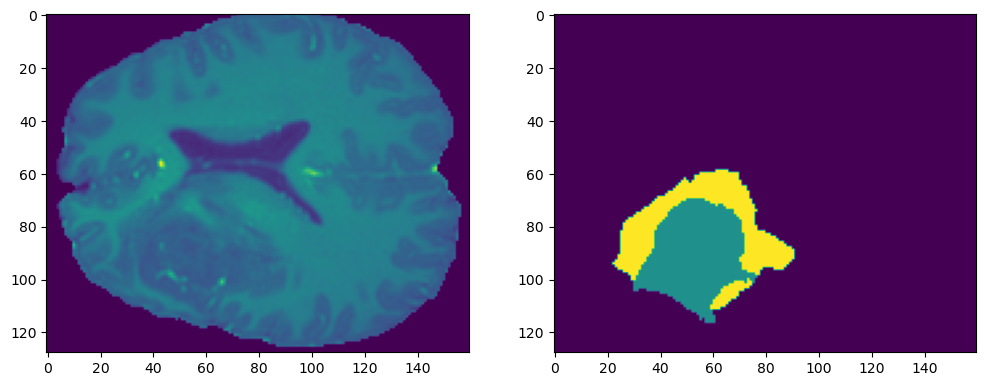

In [14]:
if str_to_bool(os.getenv('TEST_COMBINED')):
    test_combined()

x,y = test_combined()
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.imshow(x[:,:,75,1])
ax2.imshow(y[:,:,75])




get the list of files

In [15]:
mX = os.listdir(image_path)
vY = os.listdir(label_path)
mX.sort()
vY.sort()


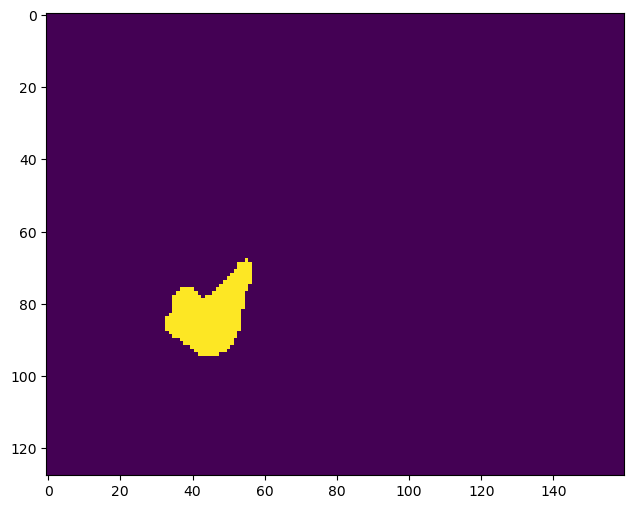

In [16]:
with gzip.open(label_path+vY[0], 'rb') as f:
         label = np.load(f)
         label = np.moveaxis(label, -1, 0)

fig, ax1 = plt.subplots(1,1, figsize = (12, 6))
ax1.imshow(label[3,:,:,75])


In [17]:
#check that the samples and labels files are synched
print(mX[555],vY[555])

sample_372.npy.gz label_372.npy.gz


In [18]:
numSamplesTest = np.int32(np.round(len(mX) * trainTestPercentage))
numSamplesTrain = len(mX) - numSamplesTest
#numSamplesTest = 10
#numSamplesTrain = 100

print("Number of Train samples:",numSamplesTrain)
print("Number of Test samples:",numSamplesTest)

Number of Train samples: 1001
Number of Test samples: 250


## Define the dataset and Loader

The dataset takes as parameters:
* mX - path to the sample numpy image file
* vY - path to the masked label file


## Pre Process Data

This section normalizes the data to have zero mean and unit variance per **channel**.  
It is required to calculate:

 * The average pixel value per channel.
 * The standard deviation per channel.

In [19]:
# Calculate the Standardization Parameters

#===========================Fill This===========================#
# 1. Calculate the mean per channel.
# 2. Calculate the standard deviation per channel.

#file_list = get_file_names_by_type(root_dir,'HGG')
#µ  = [np.mean(mX[:,:p_image_size]),np.mean(mX[:,p_image_size:p_image_size*2]),np.mean(mX[:,p_image_size*2:p_image_size*3]),np.mean(mX[:,p_image_size*3:p_image_size*4])]
#σ  = [np.std(mX[:,:p_image_size]),np.std(mX[:,p_image_size:p_image_size*2]),np.std(mX[:,p_image_size*2:p_image_size*3]),np.std(mX[:,p_image_size*3:p_image_size*4])]

#===============================================================#


    
mean_mask = ma.array([0.32969433, 0.17604456, 0.18700259, 0.23908363], mask=[ENABLE_T1,ENABLE_T1CE,ENABLE_T2,ENABLE_FLAIR])
µ=mean_mask[mean_mask.mask].data

std_mask = ma.array([0.32621744, 0.178607 , 0.20538321, 0.25072563], mask=[ENABLE_T1,ENABLE_T1CE,ENABLE_T2,ENABLE_FLAIR])
σ=std_mask[std_mask.mask].data

print("Mean:",µ)
print("std:",σ)


Mean: [0.32969433 0.17604456 0.18700259 0.23908363]
std: [0.32621744 0.178607   0.20538321 0.25072563]


### Plot the Data

In [20]:
# Histogram of Labels - TBD

#Read labels
'''
label_count = np.zeros(4)
label_files = os.listdir(label_path)
for file in label_files:
    with gzip.open(label_path+file, 'rb') as f:
         label_file = np.load(f)
         label_file = np.argmax(label_file,axis=3)
         label_count[0] += np.count_nonzero(label_file == 0)
         label_count[1] += np.count_nonzero(label_file == 1)
         label_count[2] += np.count_nonzero(label_file == 2)
         label_count[3] += np.count_nonzero(label_file == 3)
         
'''
label_count = [3.15995735e+09, 1.78609080e+07, 7.48920140e+07, 2.67111710e+07]

In [21]:
label_count

[3159957350.0, 17860908.0, 74892014.0, 26711171.0]

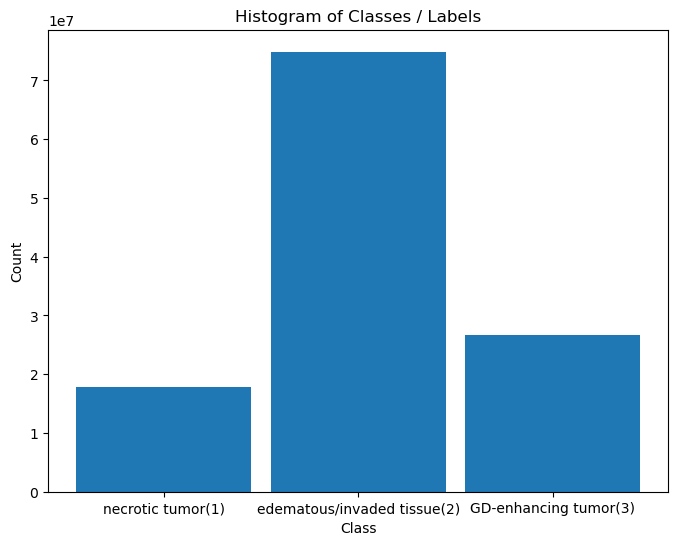

In [22]:
hF, hA = plt.subplots(figsize = (8, 6))
vLabels = [1,2,3]
lClass = ['necrotic tumor(1)','edematous/invaded tissue(2)','GD-enhancing tumor(3)']
vCounts = label_count[1:]
hA.bar(vLabels, vCounts, width = 0.9, align = 'center')
hA.set_title('Histogram of Classes / Labels')
hA.set_xlabel('Class')
hA.set_xticks(vLabels, [f'{labelVal}' for labelVal in vLabels])
hA.set_ylabel('Count')
if lClass is not None:
    hA.set_xticklabels(lClass)
    
plt.show()

## Train & Test Split

In [23]:
# Train Test Split - TBD

#numClass = len(np.unique(vY))

#===========================Fill This===========================#
# 1. Split the data into train and test (Validation) data sets (NumPy arrays).
# 2. Use stratified split.
# !! The output should be: `mXTrain`, `mXTest`, `vYTrain`, `vYTest`.

mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = numSamplesTest, train_size = numSamplesTrain, shuffle = True)
#===============================================================#

print(f'The training features data shape: {len(mXTrain)}')
print(f'The training labels data shape: {len(vYTrain)}')
print(f'The test features data shape: {len(mXTest)}')
print(f'The test labels data shape: {len(vYTest)}')
#print(f'The unique values of the labels: {np.unique(vY)}')


The training features data shape: 1001
The training labels data shape: 1001
The test features data shape: 250
The test labels data shape: 250


Create the dataset

In [24]:

mXTrain.sort()
vYTrain.sort()
mXTest.sort()
vYTest.sort()
dsTrain = ImageDatasetFromDisk(mXTrain,vYTrain)
dsTest = ImageDatasetFromDisk(mXTest,vYTest)

print(f'The training data set data len: {(len(dsTrain))}')
print(f'The test data set data len: {(len(dsTest))}')

The training data set data len: 1001
The test data set data len: 250


In [25]:
# create transform - convert image to tensor

class ToTensor(object):
    """Convert image in sample to Tensors."""

    def __call__(self, image):
         
        tImg = torch.from_numpy(image).permute(3,0,1,2)
        
        return tImg
    
class Normalize3D(object):
    
    def __init__(self,lMean,lStd):
        self.mean = lMean
        self.std = lStd
        
    """Normalize a 3d numpy image by channel"""

    def __call__(self,image):
         
        tImg = (image - self.mean)/self.std
        
        return tImg


In [26]:
# Update Transformer

#===========================Fill This===========================#
# 1. Define a transformer which normalizes the data.
oDataTrns = TorchVisionTrns.Compose([  #<! Chaining transformations
    Normalize3D(µ, σ),   #<! Normalizes the Data (https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)
    ToTensor(),      #<! Convert to Tensor (4,128,160,125)
    TorchVisionTrns.ToDtype(torch.float32, scale = True),
    ])

oLblTrns = TorchVisionTrns.Compose([  #<! Chaining transformations
    Normalize3D(µ, σ),   #<! Normalizes the Data (https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)
    ToTensor(),      #<! Convert to Tensor (4,128,160,125)
    TorchVisionTrns.ToDtype(torch.float32, scale = True),
    ])

# Update the DS transformer
dsTrain.transform = oDataTrns


dsTest.transform = oDataTrns

#===============================================================#


### Data Loaders

The dataloader is the functionality which loads the data into memory in batches.  
Its challenge is to bring data fast enough so the Hard Disk is not the training bottleneck.  
In order to achieve that, Multi Threading / Multi Process is used.


In [27]:
# Data Loader

#===========================Fill This===========================#
# 1. Create the train data loader.
# 2. Create the test data loader.
# !! Think about the values of `shuffle` and `batch_size` for the train / test.
dlTrain  = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize,drop_last=True)
dlTest   = torch.utils.data.DataLoader(dsTest, shuffle = False, batch_size = 2 * batchSize,drop_last=True)

#===============================================================#


In [28]:
# Iterate on the Loader
# The first batch.
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')


The batch features dimensions: torch.Size([1, 4, 128, 160, 128])
The batch labels dimensions: torch.Size([1, 4, 128, 160, 128])


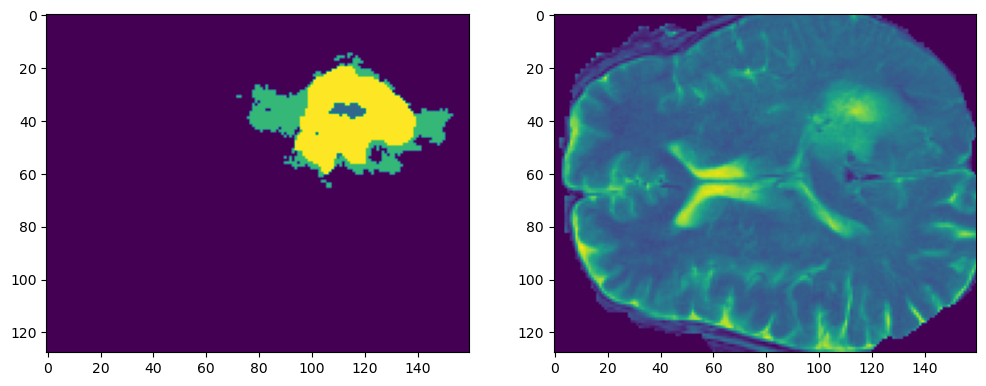

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12, 6))
x = vY.squeeze()
x = np.argmax(vY[0], axis=0)
#x = np.argmax(x,axis=0)
ax1.imshow(x[:,:,64])
ax2.imshow(tX[0,2,:,:,64])

## Define the Model

This section build 3 different models to be evaluated.

In [30]:
tX.shape

torch.Size([1, 4, 128, 160, 128])

In [31]:
# Model
# Defining a sequential model.

oModel = UNet3D(in_channels=number_of_channels, num_classes=4)
#bModel = SimpleUNet(4,4)
print(torchinfo.summary(oModel, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = device)) #<! Added `kernel_size`
#print(torchinfo.summary(bModel, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu')) #<! Added `kernel_size`


Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
UNet3D                                   --                        [1, 4, 128, 160, 128]     --
├─Conv3DBlock: 1-1                       --                        [1, 64, 64, 80, 64]       --
│    └─Conv3d: 2-1                       [3, 3, 3]                 [1, 32, 128, 160, 128]    3,488
│    └─BatchNorm3d: 2-2                  --                        [1, 32, 128, 160, 128]    64
│    └─ReLU: 2-3                         --                        [1, 32, 128, 160, 128]    --
│    └─Conv3d: 2-4                       [3, 3, 3]                 [1, 64, 128, 160, 128]    55,360
│    └─BatchNorm3d: 2-5                  --                        [1, 64, 128, 160, 128]    128
│    └─ReLU: 2-6                         --                        [1, 64, 128, 160, 128]    --
│    └─MaxPool3d: 2-7                    [2, 2, 2]                 [1, 64, 64, 80, 64]       --
├─Conv3DBlock: 1-2         

In [32]:
# Run Model
# Apply a test run.
tX      = torch.randn(1, number_of_channels, 128,160,128)
tX = tX.to(device)
oModel = oModel.to(device)
mLogits = oModel(tX) #<! Logit -> Prior to Sigmoid

print(f'The input dimensions: {tX.shape}')
print(f'The output (Logits) dimensions: {mLogits.shape}')

The input dimensions: torch.Size([1, 4, 128, 160, 128])
The output (Logits) dimensions: torch.Size([1, 4, 128, 160, 128])


## Training Loop


### Train the Model

In [33]:
# Set the Loss & Score

#===========================Fill This===========================#
# 1. Define loss function
# 2. Define score function.
hL = nn.CrossEntropyLoss()
#hS = MulticlassAccuracy(num_classes = 4)
#hS = MeanIoU(num_classes=4)
hS = Dice(num_classes=4,ignore_index=0,average="macro")

hL = hL.to(device) #<! Not required!
hS = hS.to(device)
#===============================================================#

In [34]:
# Train the Model

#===========================Fill This===========================#
# 1. Build a loop to evaluate all models.
# 2. Define a TensorBoard Writer per model to keep its score.
# !! You may use `TrainModel()`.


#oTBWriter = SummaryWriter(log_dir = TENSOR_BOARD_BASE)
#oModel = UNet3D(in_channels=number_of_channels, num_classes=4)
#oModel = oModel.to(device) #<! Transfer model to device
#oOpt = torch.optim.AdamW(oModel.parameters(), lr = 6e-4, betas = (0.9, 0.99), weight_decay = 1e-3) #<! Define optimizer
#oSch = lr_scheduler.StepLR(oOpt, step_size=10, gamma=0.1)
#oRunModel, lTrainLoss, lTrainScore, lValLoss, lValScore = TrainModel(oModel, dlTrain, dlTest, oOpt, nEpochs, hL, hS, oSch=oSch, oTBWriter=oTBWriter)
#oTBWriter.close()

#===============================================================#

* <font color='brown'>(**#**)</font> Run `tensorboard --logdir=TB` from the Jupyter notebook path.
* <font color='green'>(**@**)</font> Optimize the model search to get above 92% accuracy in validation set.

Checkpoint keys: dict_keys(['Model', 'Optimizer', 'Scheduler'])
Shape of input tensor: torch.Size([1, 4, 128, 160, 128])
Shape of random label: torch.Size([1, 4, 128, 160, 128])
loss: tensor(0.1865, device='cuda:0', dtype=torch.float64)
unique labels: [0 1 2 3]
Random label shape after squeeze: torch.Size([128, 160, 128])
score: tensor(0.1555)


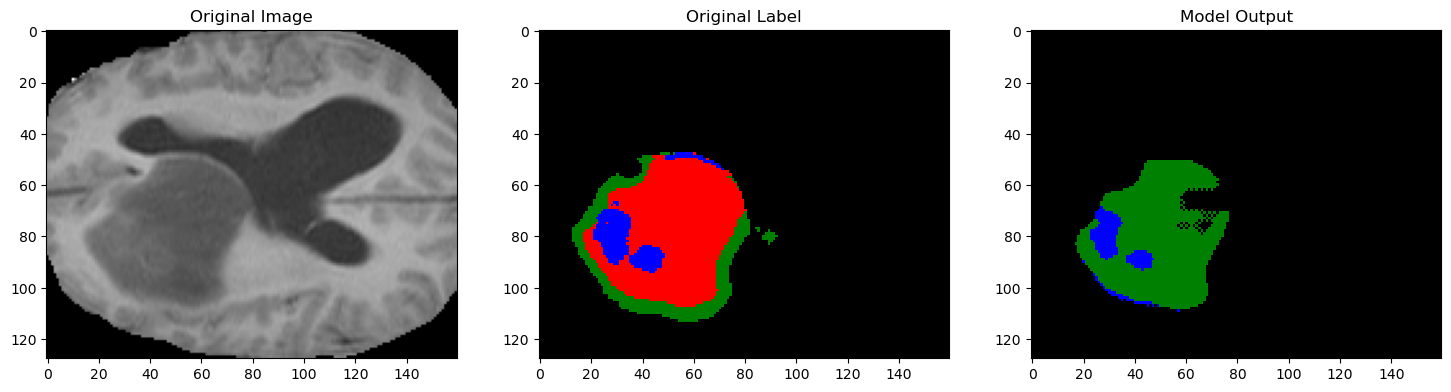

output labels [0 2 3]
output labels [0 1 2 3]
(128, 160)
torch.Size([128, 160])


In [35]:
from matplotlib.colors import ListedColormap

from matplotlib.colors import ListedColormap

mXTrain = [f"sample_96.npy.gz"]
vYTrain = [f"label_96.npy.gz"]

# Initialize dataset

# Load the trained model
model_path = 'BestModel.pt'  # Replace with your model path
model = UNet3D(in_channels=4, num_classes=4)  # Ensure in_channels is set to 4 to match the checkpoint


# Load the entire checkpoint
checkpoint = torch.load(model_path)
# Ensure the keys in the checkpoint match the model state_dict
print("Checkpoint keys:", checkpoint.keys())

# Extract only the model state_dict
model.load_state_dict(checkpoint['Model'])
model.eval()

dsTrain = ImageDatasetFromDisk(mXTrain, vYTrain)
dsTrain.transform = oDataTrns
dlTrain  = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize,drop_last=True)
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors



# Check the shape of the tensor before passing to model
print("Shape of input tensor:", tX.shape)
print("Shape of random label:", vY.shape)

# Convert random_label to single-channel by taking argmax along the channel dimension
random_label = vY.squeeze()


# Run the example through the model
mode = model.to(device)
tX = tX.to(device)
vY = vY.to(device)
with torch.no_grad():
    output = model(tX)  # Shape: [batch_size, num_classes, D, H, W]

print('loss:',hL(output, vY))

# Print the output tensor before applying argmax
#print("Model output before argmax:", output)

# Process the output to create a 2D visualization
output = output.cpu()
output = output.argmax(dim=1).squeeze() # Get the class with the highest score
random_label = np.argmax(random_label, axis=0)
print('unique labels:',np.unique(random_label))
print("Random label shape after squeeze:", random_label.shape)
hS = hS.cpu()
print('score:',hS(output,random_label))
output = output.numpy()


output_slice = output[:,:,64]  # Adjust indexing to ensure correct slicing
label_slice = random_label[:,:,64]  # Ensure the label slice is correctly selected

# Define a colormap for different classes
cmap = ListedColormap(['black', 'red', 'green', 'blue'])

tX = tX.cpu()
# Visualize the result
plt.figure(figsize=(18, 6))

# Original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(tX[0, 0, :, :,64], cmap='gray')  # Adjust the slice for visualization

# Original label
plt.subplot(1, 3, 2)
plt.title('Original Label')
plt.imshow(label_slice, cmap=cmap, interpolation='nearest')  # Use the discrete colormap

# Model output
plt.subplot(1, 3, 3)
plt.title('Model Output')
plt.imshow(output_slice, cmap=cmap, interpolation='nearest')  # Use the discrete colormap

plt.show()

print('output labels',np.unique(output_slice))
print('output labels',np.unique(label_slice))
print(output_slice.shape)
print(label_slice.shape)

Shape of input tensor: torch.Size([1, 4, 128, 160, 128])
Shape of random label: torch.Size([1, 4, 128, 160, 128])
unique labels: [0 1 2 3]
Random label shape after squeeze: torch.Size([128, 160, 128])


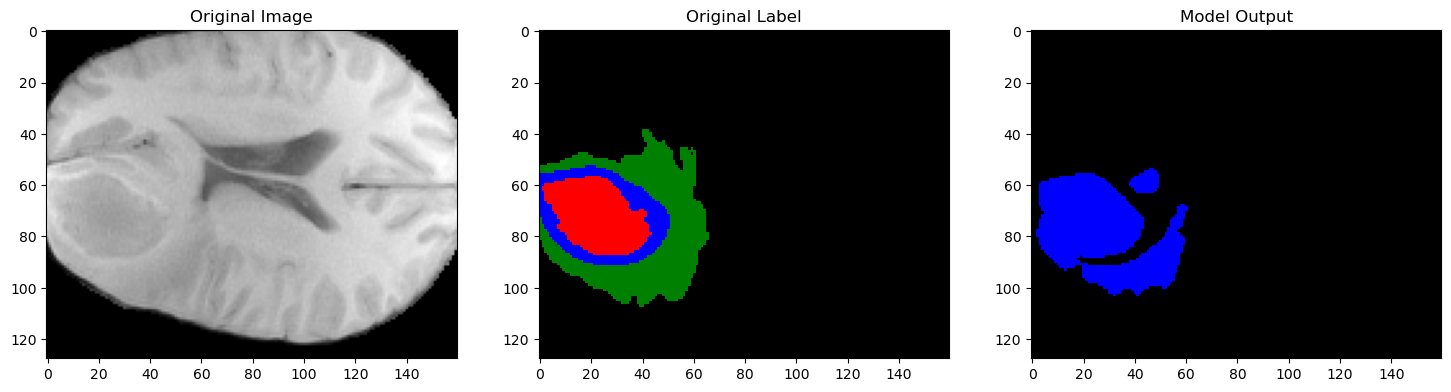

output labels [0 2]
output labels [0 1 2 3]
(128, 160)
torch.Size([128, 160])
Shape of input tensor: torch.Size([1, 4, 128, 160, 128])
Shape of random label: torch.Size([1, 4, 128, 160, 128])
unique labels: [0 1 2 3]
Random label shape after squeeze: torch.Size([128, 160, 128])


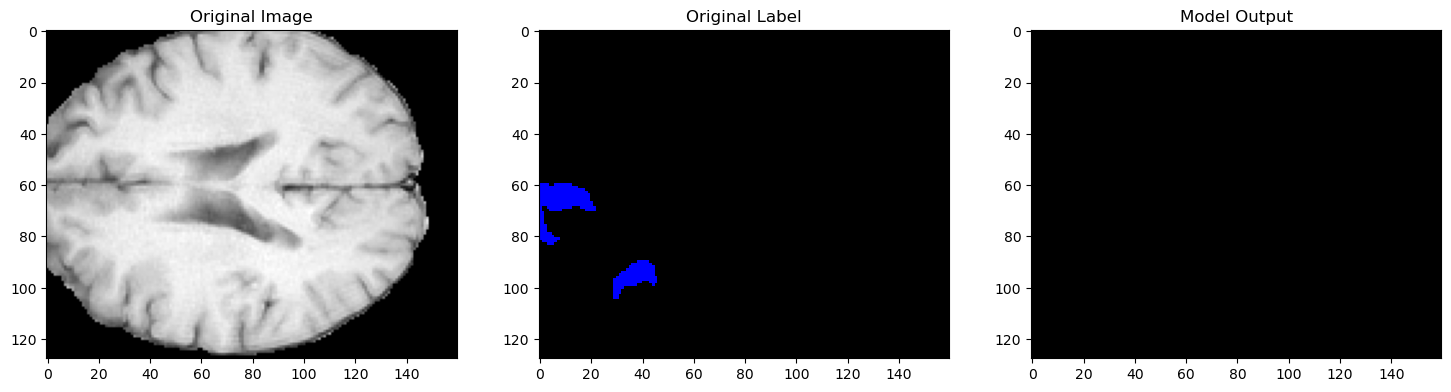

output labels [0]
output labels [0 2]
(128, 160)
torch.Size([128, 160])
Shape of input tensor: torch.Size([1, 4, 128, 160, 128])
Shape of random label: torch.Size([1, 4, 128, 160, 128])
unique labels: [0 1 2 3]
Random label shape after squeeze: torch.Size([128, 160, 128])


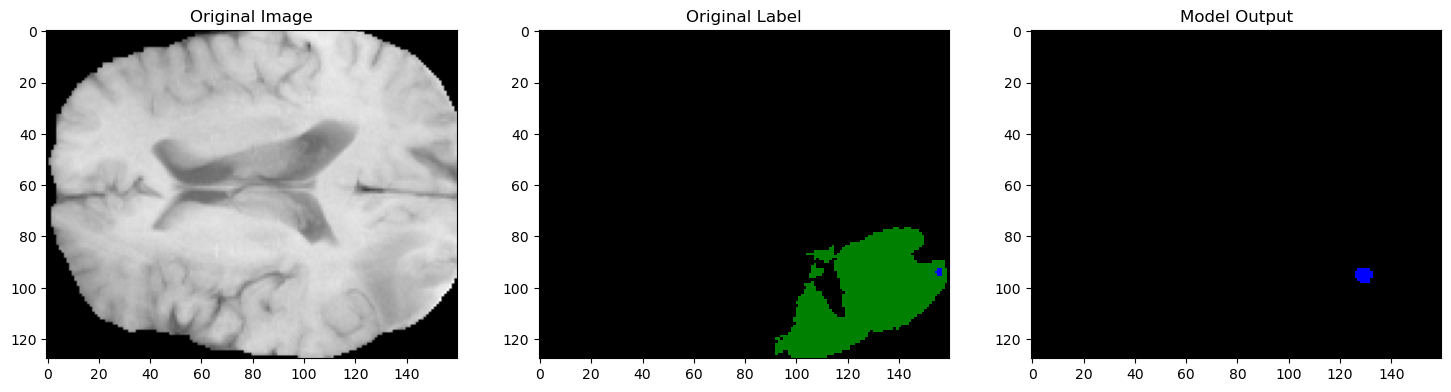

output labels [0 2]
output labels [0 2 3]
(128, 160)
torch.Size([128, 160])
Shape of input tensor: torch.Size([1, 4, 128, 160, 128])
Shape of random label: torch.Size([1, 4, 128, 160, 128])
unique labels: [0 1 2 3]
Random label shape after squeeze: torch.Size([128, 160, 128])


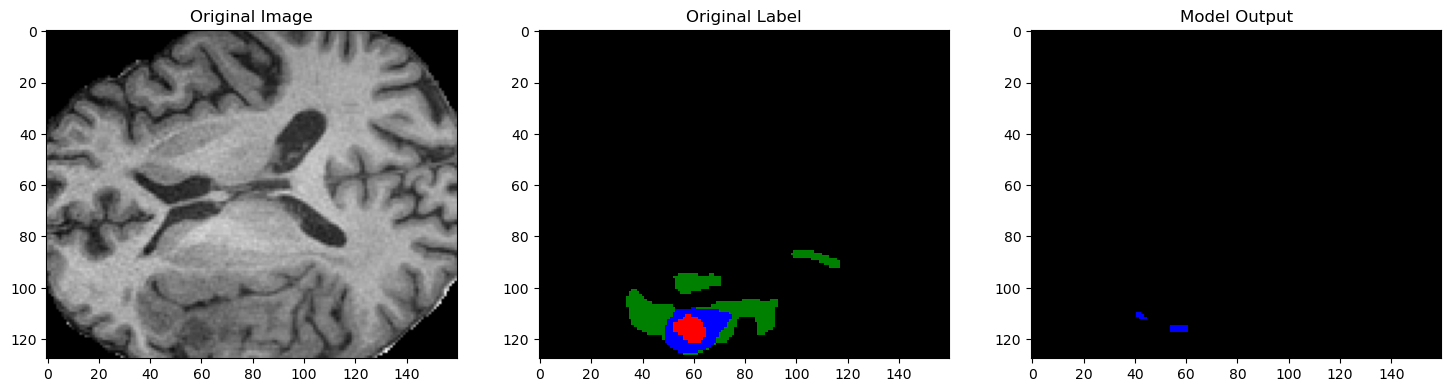

output labels [0 2]
output labels [0 1 2 3]
(128, 160)
torch.Size([128, 160])


In [38]:
from visualization import visualization_model_result_as_2d
visualization_model_result_as_2d(model, 4)
visualization_model_result_as_2d(model, 6)
visualization_model_result_as_2d(model, 78)
visualization_model_result_as_2d(model, 355)